In [1]:
import numpy as np
import pandas as pd
import config
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import yfinance as yf
from __future__ import annotations
import requests
import bs4 as bs
import matplotlib.pyplot as plt 

In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [3]:
#function to get Dow Jones Industrial Average tickers
def get_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average#Components')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []

    # Import stock tickers
    for row in table.findAll('tr')[1:]: 
        ticker = row.findAll('td')[1].text
        tickers.append(ticker)

    # Store stock tickers into a list
    tickers = [s.replace('\n', '') for s in tickers]
    
    return tickers

#function to pick 5 random tickers from the Dow Jones Industrial Average
def get_random_tickers():
    tickers = get_tickers()
    random_tickers = np.random.choice(tickers, 5, replace=False)
    return random_tickers

In [4]:
#a = get_random_tickers()
# fixed seed from one random tickers generator (in case every time reopen the notebook it will change)
a = ['GS', 'MSFT', 'AAPL', 'NKE', 'JNJ']
y = yf.download(a,start='2001-01-01',end='2021-01-01')

[*********************100%***********************]  5 of 5 completed


In [117]:
adj_close_y = y['Adj Close']

          AAPL        GS       JNJ      MSFT       NKE
AAPL  1.000000  0.708850  0.901981  0.967782  0.958991
GS    0.708850  1.000000  0.820308  0.671060  0.773456
JNJ   0.901981  0.820308  1.000000  0.880158  0.962942
MSFT  0.967782  0.671060  0.880158  1.000000  0.935675
NKE   0.958991  0.773456  0.962942  0.935675  1.000000


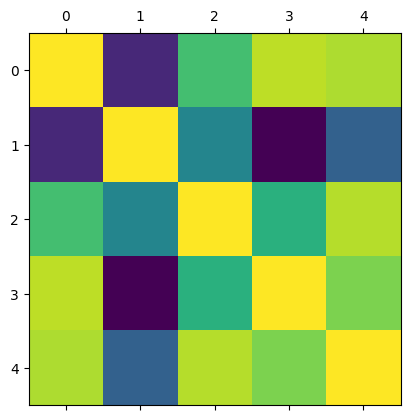

In [6]:
print(adj_close_y.corr())
plt.matshow(adj_close_y.corr())
plt.savefig('2.jpg',dpi=400)

In [ ]:
eff_rate.mean()

## Markowitz mean-variance portfolio

In [10]:
len(y)

5032

In [118]:
training_set = adj_close_y[:3522]
test_set = adj_close_y[3522:]

Import effr as the risk free rate

In [242]:
effr = pd.read_excel('Search.xlsx')

c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [243]:
eff_rate = effr[['Effective Date','Rate (%)']]

In [244]:
# Turn year rate into daily rate
eff_rate['Rate (%)'] = eff_rate['Rate (%)'].apply(lambda x: x/252)

C:\Users\47965\AppData\Local\Temp\ipykernel_26172\2890525887.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [245]:
# Reindex
eff_rate = eff_rate.set_index('Effective Date')

In [246]:
eff_rate.index.names = ['Date']
eff_rate = eff_rate.iloc[::-1]

In [247]:
eff_rate.index = pd.to_datetime(eff_rate.index)

In [252]:
eff_rate['Rate (%)'][-1]

0.0002777777777777778

In [254]:
eff_rate

,Rate (%)
Date,
2001-01-02,0.026468
2001-01-03,0.025198
2001-01-04,0.023492
2001-01-05,0.023135
2001-01-08,0.023730
...,...
2021-12-27,0.000317
2021-12-28,0.000317
2021-12-29,0.000317


In [126]:
cum = (1 + eff_rate['Rate (%)'] * 0.01).cumprod()

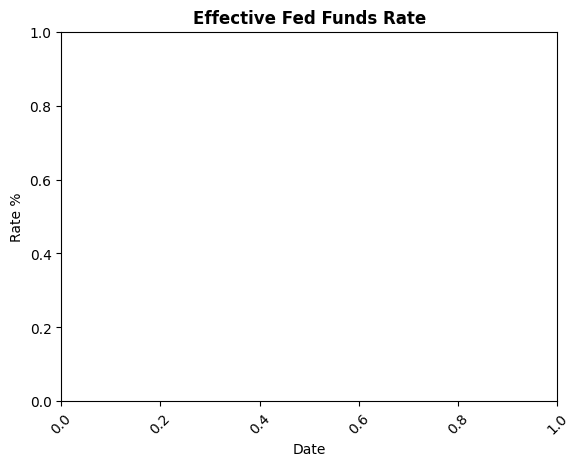

In [253]:
eff_rate.plot()
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Rate %')
plt.title('Effective Fed Funds Rate',fontsize='large',fontweight='bold')
plt.show()

training set

In [128]:
# only get the Adj Close
stock_prices_training = training_set

# Calculate the daily returns of the adjusted close price
stock_returns_training = stock_prices_training.pct_change()

In [129]:
assets_train = pd.merge(training_set,cum,how='left',left_index=True,right_index=True)

In [130]:
assets_train

,AAPL,GS,JNJ,MSFT,NKE,Rate (%)
Date,,,,,,
2001-01-02,0.226078,74.949112,28.563032,13.530790,5.320995,1.000265
2001-01-03,0.248876,86.350349,27.652941,14.954061,5.499182,1.000517
2001-01-04,0.259326,84.294395,27.057861,15.110033,5.640502,1.000752
2001-01-05,0.248876,80.649734,27.407906,15.324500,5.394729,1.000983
2001-01-08,0.251726,79.528320,27.372908,15.266012,5.665077,1.001221
...,...,...,...,...,...,...
2014-12-26,25.612764,168.307053,84.135475,41.684540,44.337116,1.270056
2014-12-29,25.594791,168.944275,84.351715,41.310181,44.552326,1.270062
2014-12-30,25.282465,168.530930,84.375732,40.935822,44.359997,1.270069


In [131]:
# import the relevant modules
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

In [132]:
# Calculate expected returns mu
mu = expected_returns.mean_historical_return(assets_train)
print(mu)

# Calculate the covariance matrix sigma
sigma = risk_models.sample_cov(assets_train)
print(sigma)

AAPL        0.398694
GS          0.059204
JNJ         0.079988
MSFT        0.082025
NKE         0.162297
Rate (%)    0.017239
dtype: float64
              AAPL        GS       JNJ      MSFT       NKE  Rate (%)
AAPL      0.155690  0.061863  0.016978  0.052880  0.038852  0.000005
GS        0.061863  0.146753  0.024169  0.057029  0.046096 -0.000006
JNJ       0.016978  0.024169  0.034028  0.020174  0.017500 -0.000002
MSFT      0.052880  0.057029  0.020174  0.087536  0.033027 -0.000002
NKE       0.038852  0.046096  0.017500  0.033027  0.082760 -0.000009
Rate (%)  0.000005 -0.000006 -0.000002 -0.000002 -0.000009  0.000001


In [25]:
ef_Sharpe = EfficientFrontier(mu, sigma)

In [26]:
# Calculate weights for the maximum Sharpe ratio portfolio
raw_weights_maxsharpe = ef_Sharpe.max_sharpe()
print(raw_weights_maxsharpe)
cleaned_weights_maxsharpe = ef_Sharpe.clean_weights()
cleaned_weights_maxsharpe

OrderedDict([('AAPL', 0.7074425554670789), ('GS', 0.0), ('JNJ', 0.1058904777911267), ('MSFT', 0.0), ('NKE', 0.1866669667417944), ('Rate (%)', 0.0)])


OrderedDict([('AAPL', 0.70744),
             ('GS', 0.0),
             ('JNJ', 0.10589),
             ('MSFT', 0.0),
             ('NKE', 0.18667),
             ('Rate (%)', 0.0)])

In [27]:
ef_Sharpe.portfolio_performance(verbose=True)

Expected annual return: 32.1%
Annual volatility: 30.8%
Sharpe Ratio: 0.98


(0.3208185795362072, 0.30770301963425056, 0.9776263485934374)

In [116]:
return_train  = pd.merge(stock_returns_training,eff_rate,how='left',left_index=True,right_index=True)

In [117]:
portfolio_weights_train = np.array([0.70744, 0.0, 0.10589, 0.0, 0.18667, 0.0])

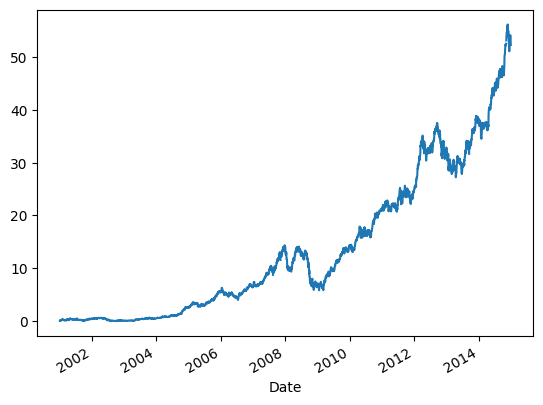

In [118]:
weighted_returns = return_train.mul(portfolio_weights_train, axis=1).dropna()
weighted_returns.head()

return_train['Portfolio'] = weighted_returns.sum(axis=1)
return_train.dropna()

# Plot the cumulative portfolio returns over time
cumulative_returns_port = ((1 + return_train['Portfolio']).cumprod()-1 )
cumulative_returns_port.plot()
plt.show()

Test set

In [138]:
assets_test = pd.merge(test_set,cum,how='left',left_index=True,right_index=True)

In [139]:
assets_test

,AAPL,GS,JNJ,MSFT,NKE,Rate (%)
Date,,,,,,
2015-01-05,23.873644,162.184448,83.118416,40.335098,42.812340,1.270084
2015-01-06,23.875889,158.903549,82.709999,39.743092,42.560505,1.270090
2015-01-07,24.210682,161.271667,84.535889,40.248047,43.439651,1.270096
2015-01-08,25.140907,163.846420,85.200592,41.432076,44.442410,1.270102
2015-01-09,25.167875,161.331909,84.039368,41.083832,43.952477,1.270108
...,...,...,...,...,...,...
2020-12-24,130.205780,243.526062,143.879700,218.300934,138.653900,1.346827
2020-12-28,134.862671,246.786896,144.559097,220.466827,139.466614,1.346832
2020-12-29,133.067001,245.284836,145.455597,219.672974,138.624542,1.346837


In [140]:
# Calculate expected returns mu
mu = expected_returns.mean_historical_return(assets_test)
print(mu)

# Calculate the covariance matrix sigma
sigma = risk_models.sample_cov(assets_test)
print(sigma)

AAPL        0.328691
GS          0.075444
JNJ         0.101780
MSFT        0.325453
NKE         0.216643
Rate (%)    0.009848
dtype: float64
              AAPL        GS       JNJ          MSFT       NKE      Rate (%)
AAPL      0.087720  0.047560  0.024426  5.636599e-02  0.037106 -1.335338e-06
GS        0.047560  0.092586  0.025960  4.721989e-02  0.042126 -3.787955e-06
JNJ       0.024426  0.025960  0.037445  2.729821e-02  0.022088 -1.931445e-06
MSFT      0.056366  0.047220  0.027298  7.744473e-02  0.038416  5.546960e-07
NKE       0.037106  0.042126  0.022088  3.841609e-02  0.075081 -3.342954e-06
Rate (%) -0.000001 -0.000004 -0.000002  5.546960e-07 -0.000003  2.807466e-07


In [141]:
ef_Sharpe = EfficientFrontier(mu, sigma)

In [142]:
# Calculate weights for the maximum Sharpe ratio portfolio
raw_weights_maxsharpe = ef_Sharpe.max_sharpe()
print(raw_weights_maxsharpe)
cleaned_weights_maxsharpe = ef_Sharpe.clean_weights()
cleaned_weights_maxsharpe

OrderedDict([('AAPL', 0.373326055355749), ('GS', 0.0), ('JNJ', 0.0), ('MSFT', 0.5155904550281643), ('NKE', 0.1110834896160866), ('Rate (%)', 0.0)])


OrderedDict([('AAPL', 0.37333),
             ('GS', 0.0),
             ('JNJ', 0.0),
             ('MSFT', 0.51559),
             ('NKE', 0.11108),
             ('Rate (%)', 0.0)])

In [143]:
ef_Sharpe.portfolio_performance(verbose=True)

Expected annual return: 31.5%
Annual volatility: 25.1%
Sharpe Ratio: 1.17


(0.31457459666129617, 0.2508319394994366, 1.1743902999321096)

## Reinforcement learning

In [5]:
# Class from FinRL lib that retrieving daily stock data from Yahoo Finance API
class YahooDownloader:
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API
    Attributes
    ----------
        start_date : str
            start date of the data (modified from neofinrl_config.py)
        end_date : str
            end date of the data (modified from neofinrl_config.py)
        ticker_list : list
            a list of stock tickers (modified from neofinrl_config.py)
    Methods
    -------
    fetch_data()
        Fetches data from yahoo API
    """

    def __init__(self, start_date: str, end_date: str, ticker_list: list):
        self.start_date = start_date
        self.end_date = end_date
        self.ticker_list = ticker_list

    def fetch_data(self, proxy=None) -> pd.DataFrame:
        """Fetches data from Yahoo API
        Parameters
        ----------
        Returns
        -------
        `pd.DataFrame`
            7 columns: A date, open, high, low, close, volume and tick symbol
            for the specified stock ticker
        """
        # Download and save the data in a pandas DataFrame:
        
        #add cash
        temp = yf.download(
                'AAPL', start=self.start_date, end=self.end_date, proxy=proxy
            )
        a = pd.read_excel('Search.xlsx')
        a = a[['Effective Date','Rate (%)']]
        a['Rate (%)'] = a['Rate (%)'].apply(lambda x: x/252)
        a.index.names = ['Date']
        a = a.iloc[::-1]
        a.index = pd.to_datetime(a.index)
        data_df = pd.DataFrame(np.ones(temp.shape),index=temp.index,columns=temp.columns)
        data_df['tic'] = 'cash'
        data_df['Open'][0] = 1
        data_df['Adj Close'][0] = (1 + a['Rate (%)'][0]/100) * data_df['Open'][0]
        data_df['High'][0] = data_df['Adj Close'][0]
        data_df['Low'][0] = data_df['Open'][0]
        data_df['Volume'][0] = 50000000
        for i in range(1,len(temp)):
            data_df['Open'][i] = data_df['Adj Close'][i-1]
            data_df['Adj Close'][i] = (1 + a['Rate (%)'][0]/100) * data_df['Open'][i]
            data_df['High'][i] = data_df['Adj Close'][i]
            data_df['Low'][i] = data_df['Open'][i]
            data_df['Volume'][i] = 50000000
        num_failures = 0
        for tic in self.ticker_list:
            temp_df = yf.download(
                tic, start=self.start_date, end=self.end_date, proxy=proxy
            )
            temp_df["tic"] = tic
            if len(temp_df) > 0:
                data_df = pd.concat([data_df,temp_df])
            else:
                num_failures += 1
        if num_failures == len(self.ticker_list):
            raise ValueError("no data is fetched.")
        # reset the index, we want to use numbers as index instead of dates
        data_df = data_df.reset_index()
        try:
            # convert the column names to standardized names
            data_df.columns = [
                "date",
                "open",
                "high",
                "low",
                "close",
                "adjcp",
                "volume",
                "tic",
            ]
            # use adjusted close price instead of close price
            data_df["close"] = data_df["adjcp"]
            # drop the adjusted close price column
            data_df = data_df.drop(labels="adjcp", axis=1)
        except NotImplementedError:
            print("the features are not supported currently")
        # create day of the week column (monday = 0)
        data_df["day"] = data_df["date"].dt.dayofweek
        # convert date to standard string format, easy to filter
        data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
        # drop missing data
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        print("Shape of DataFrame: ", data_df.shape)
        # print("Display DataFrame: ", data_df.head())
        data_df = data_df.sort_values(by=["date", "tic"]).reset_index(drop=True)
        
        return data_df

    def select_equal_rows_stock(self, df):
        df_check = df.tic.value_counts()
        df_check = pd.DataFrame(df_check).reset_index()
        df_check.columns = ["tic", "counts"]
        mean_df = df_check.counts.mean()
        equal_list = list(df.tic.value_counts() >= mean_df)
        names = df.tic.value_counts().index
        select_stocks_list = list(names[equal_list])
        df = df[df.tic.isin(select_stocks_list)]
        return df

In [6]:
data = YahooDownloader(start_date='2001-01-01',end_date='2022-01-01',ticker_list=a)
df = data.fetch_data()

[*********************100%***********************]  1 of 1 completed


c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\47965\AppData\Local\Temp\ipykernel_26172\2094787297.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['Open'][0] = 1
C:\Users\47965\AppData\Local\Temp\ipykernel_26172\2094787297.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['Adj Close'][0] = (1 + a['Rate (%)'][0]/100) * data_df['Open'][0]
C:\Users\47965\AppData\Local\Temp\ipykernel_26172\2094787297.py:

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (31704, 8)


In [7]:
#check data structure
df.head(10)

,date,open,high,low,close,volume,tic,day
0,2001-01-02,0.265625,0.272321,0.260045,0.226078,452312000.0,AAPL,1
1,2001-01-02,104.375000,105.500000,97.500000,74.949112,3202400.0,GS,1
2,2001-01-02,52.000000,52.343750,50.781250,28.563032,8855200.0,JNJ,1
3,2001-01-02,22.062500,22.500000,21.437500,13.530795,82413200.0,MSFT,1
4,2001-01-02,6.843750,6.937500,6.703125,5.320995,28993600.0,NKE,1
5,2001-01-02,1.000000,1.000265,1.000000,1.000265,50000000.0,cash,1
6,2001-01-03,0.258929,0.297991,0.257813,0.248876,817073600.0,AAPL,2
7,2001-01-03,100.062500,115.500000,98.875000,86.350342,7355200.0,GS,2
8,2001-01-03,51.500000,51.843750,48.937500,27.652929,11326000.0,JNJ,2
9,2001-01-03,21.593750,24.437500,21.562500,14.954061,135962200.0,MSFT,2


In [8]:
import config
from stockstats import StockDataFrame as Sdf
#add technical indicator
class FeatureEngineer:
    """Provides methods for preprocessing the stock price data
    Attributes
    ----------
        use_technical_indicator : boolean
            we technical indicator or not
        tech_indicator_list : list
            a list of technical indicator names (modified from neofinrl_config.py)
        use_turbulence : boolean
            use turbulence index or not
        user_defined_feature:boolean
            use user defined features or not
    Methods
    -------
    preprocess_data()
        main method to do the feature engineering
    """

    def __init__(
        self,
        use_technical_indicator=True,
        tech_indicator_list=config.INDICATORS,
        use_vix=False,
        use_turbulence=False,
        user_defined_feature=False,
    ):
        self.use_technical_indicator = use_technical_indicator
        self.tech_indicator_list = tech_indicator_list
        self.use_vix = use_vix
        self.use_turbulence = use_turbulence
        self.user_defined_feature = user_defined_feature

    def preprocess_data(self, df):
        """main method to do the feature engineering
        @:param config: source dataframe
        @:return: a DataMatrices object
        """
        # clean data
        df = self.clean_data(df)

        # add technical indicators using stockstats
        if self.use_technical_indicator:
            df = self.add_technical_indicator(df)
            print("Successfully added technical indicators")

        # add vix for multiple stock
        if self.use_vix:
            df = self.add_vix(df)
            print("Successfully added vix")

        # add turbulence index for multiple stock
        if self.use_turbulence:
            df = self.add_turbulence(df)
            print("Successfully added turbulence index")

        # add user defined feature
        if self.user_defined_feature:
            df = self.add_user_defined_feature(df)
            print("Successfully added user defined features")

        # fill the missing values at the beginning and the end
        df = df.fillna(method="ffill").fillna(method="bfill")
        return df

    def clean_data(self, data):
        """
        clean the raw data
        deal with missing values
        reasons: stocks could be delisted, not incorporated at the time step
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df = df.sort_values(["date", "tic"], ignore_index=True)
        df.index = df.date.factorize()[0]
        merged_closes = df.pivot_table(index="date", columns="tic", values="close")
        merged_closes = merged_closes.dropna(axis=1)
        tics = merged_closes.columns
        df = df[df.tic.isin(tics)]
        # df = data.copy()
        # list_ticker = df["tic"].unique().tolist()
        # only apply to daily level data, need to fix for minute level
        # list_date = list(pd.date_range(df['date'].min(),df['date'].max()).astype(str))
        # combination = list(itertools.product(list_date,list_ticker))

        # df_full = pd.DataFrame(combination,columns=["date","tic"]).merge(df,on=["date","tic"],how="left")
        # df_full = df_full[df_full['date'].isin(df['date'])]
        # df_full = df_full.sort_values(['date','tic'])
        # df_full = df_full.fillna(0)
        return df

    def add_technical_indicator(self, data):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df = df.sort_values(by=["tic", "date"])
        stock = Sdf.retype(df.copy())
        unique_ticker = stock.tic.unique()

        for indicator in self.tech_indicator_list:
            indicator_df = pd.DataFrame()
            for i in range(len(unique_ticker)):
                try:
                    temp_indicator = stock[stock.tic == unique_ticker[i]][indicator]
                    temp_indicator = pd.DataFrame(temp_indicator)
                    temp_indicator["tic"] = unique_ticker[i]
                    temp_indicator["date"] = df[df.tic == unique_ticker[i]][
                        "date"
                    ].to_list()
                    indicator_df = pd.concat([indicator_df,
                        temp_indicator], ignore_index=True
                    )
                except Exception as e:
                    print(e)
            df = df.merge(
                indicator_df[["tic", "date", indicator]], on=["tic", "date"], how="left"
            )
        df = df.sort_values(by=["date", "tic"])
        return df
        # df = data.set_index(['date','tic']).sort_index()
        # df = df.join(df.groupby(level=0, group_keys=False).apply(lambda x, y: Sdf.retype(x)[y], y=self.tech_indicator_list))
        # return df.reset_index()

    def add_user_defined_feature(self, data):
        """
         add user defined features
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df["daily_return"] = df.close.pct_change(1)
        # df['return_lag_1']=df.close.pct_change(2)
        # df['return_lag_2']=df.close.pct_change(3)
        # df['return_lag_3']=df.close.pct_change(4)
        # df['return_lag_4']=df.close.pct_change(5)
        return df

    def add_vix(self, data):
        """
        add vix from yahoo finance
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df_vix = YahooDownloader(
            start_date=df.date.min(), end_date=df.date.max(), ticker_list=["^VIX"]
        ).fetch_data()
        vix = df_vix[["date", "close"]]
        vix.columns = ["date", "vix"]

        df = df.merge(vix, on="date")
        df = df.sort_values(["date", "tic"]).reset_index(drop=True)
        return df

    def add_turbulence(self, data):
        """
        add turbulence index from a precalcualted dataframe
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        turbulence_index = self.calculate_turbulence(df)
        df = df.merge(turbulence_index, on="date")
        df = df.sort_values(["date", "tic"]).reset_index(drop=True)
        return df

    def calculate_turbulence(self, data):
        """calculate turbulence index based on dow 30"""
        # can add other market assets
        df = data.copy()
        df_price_pivot = df.pivot(index="date", columns="tic", values="close")
        # use returns to calculate turbulence
        df_price_pivot = df_price_pivot.pct_change()

        unique_date = df.date.unique()
        # start after a year
        start = 252
        turbulence_index = [0] * start
        # turbulence_index = [0]
        count = 0
        for i in range(start, len(unique_date)):
            current_price = df_price_pivot[df_price_pivot.index == unique_date[i]]
            # use one year rolling window to calcualte covariance
            hist_price = df_price_pivot[
                (df_price_pivot.index < unique_date[i])
                & (df_price_pivot.index >= unique_date[i - 252])
            ]
            # Drop tickers which has number missing values more than the "oldest" ticker
            filtered_hist_price = hist_price.iloc[
                hist_price.isna().sum().min() :
            ].dropna(axis=1)

            cov_temp = filtered_hist_price.cov()
            current_temp = current_price[[x for x in filtered_hist_price]] - np.mean(
                filtered_hist_price, axis=0
            )
            # cov_temp = hist_price.cov()
            # current_temp=(current_price - np.mean(hist_price,axis=0))

            temp = current_temp.values.dot(np.linalg.pinv(cov_temp)).dot(
                current_temp.values.T
            )
            if temp > 0:
                count += 1
                if count > 2:
                    turbulence_temp = temp[0][0]
                else:
                    # avoid large outlier because of the calculation just begins
                    turbulence_temp = 0
            else:
                turbulence_temp = 0
            turbulence_index.append(turbulence_temp)
        try:
            turbulence_index = pd.DataFrame(
                {"date": df_price_pivot.index, "turbulence": turbulence_index}
            )
        except ValueError:
            raise Exception("Turbulence information could not be added.")
        return turbulence_index

In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [10]:
df.head(12)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2001-01-02,0.265625,0.272321,0.260045,0.226078,452312000.0,AAPL,1,0.000000,0.269719,0.205236,100.0,66.666667,100.0,0.226078,0.226078
5284,2001-01-02,104.375000,105.500000,97.500000,74.949112,3202400.0,GS,1,0.000000,0.269719,0.205236,100.0,66.666667,100.0,74.949112,74.949112
10568,2001-01-02,52.000000,52.343750,50.781250,28.563032,8855200.0,JNJ,1,0.000000,0.269719,0.205236,100.0,66.666667,100.0,28.563032,28.563032
15852,2001-01-02,22.062500,22.500000,21.437500,13.530795,82413200.0,MSFT,1,0.000000,0.269719,0.205236,100.0,66.666667,100.0,13.530795,13.530795
21136,2001-01-02,6.843750,6.937500,6.703125,5.320995,28993600.0,NKE,1,0.000000,0.269719,0.205236,100.0,66.666667,100.0,5.320995,5.320995
26420,2001-01-02,1.000000,1.000265,1.000000,1.000265,50000000.0,cash,1,0.000000,0.269719,0.205236,100.0,66.666667,100.0,1.000265,1.000265
1,2001-01-03,0.258929,0.297991,0.257813,0.248876,817073600.0,AAPL,2,0.000511,0.269719,0.205236,100.0,66.666667,100.0,0.237477,0.237477
5285,2001-01-03,100.062500,115.500000,98.875000,86.350342,7355200.0,GS,2,0.255797,96.773501,64.525953,100.0,66.666667,100.0,80.649727,80.649727
10569,2001-01-03,51.500000,51.843750,48.937500,27.652929,11326000.0,JNJ,2,-0.020419,29.395061,26.820901,0.0,-66.666667,100.0,28.107981,28.107981
15853,2001-01-03,21.593750,24.437500,21.562500,14.954061,135962200.0,MSFT,2,0.031932,16.255229,12.229627,100.0,66.666667,100.0,14.242428,14.242428


In [11]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [12]:
df['cov_list'].tail(1).values

array([array([[2.50042624e-04, 2.92372389e-05, 2.26164686e-05, 1.43148884e-04,
               7.24954796e-05, 0.00000000e+00],
              [2.92372389e-05, 2.52142576e-04, 2.02860007e-05, 6.55965791e-06,
               6.51873839e-05, 0.00000000e+00],
              [2.26164686e-05, 2.02860007e-05, 8.33855250e-05, 2.45563431e-05,
               1.58390728e-05, 0.00000000e+00],
              [1.43148884e-04, 6.55965791e-06, 2.45563431e-05, 1.75812848e-04,
               7.42187449e-05, 0.00000000e+00],
              [7.24954796e-05, 6.51873839e-05, 1.58390728e-05, 7.42187449e-05,
               3.10709543e-04, 0.00000000e+00],
              [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
               0.00000000e+00, 0.00000000e+00]])                              ],
      dtype=object)

In [13]:
df.shape

(30192, 18)

In [14]:
def data_split(df, start, end, target_date_col="date"):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df[target_date_col] >= start) & (df[target_date_col] < end)]
    data = data.sort_values([target_date_col, "tic"], ignore_index=True)
    data.index = data[target_date_col].factorize()[0]
    return data

In [15]:
train = data_split(df, '2000-01-01','2015-01-02')
trade = data_split(df,'2015-01-04', '2021-12-31')

In [268]:
len(train.index.unique())

3269

In [65]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[0,0,0,0,0,1]]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()
            
            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))
            
            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data
            
            
            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights) - sum(abs(np.array(self.actions_memory[-2]-weights))) * self.transaction_cost_pct
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return) 
            self.portfolio_value = new_portfolio_value
            
            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = portfolio_return 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling
            #self.reward = self.portfolio_value * portfolio_return - sum(abs(np.array(self.actions_memory[-2]-weights))) * self.transaction_cost_pct

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list  ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[0,0,0,0,0,1]]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [66]:
class StockPortfolioEnv2(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[0,0,0,0,0,1]]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()
            
            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))
            
            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data
            
            
            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights) - sum(abs(np.array(self.actions_memory[-2]-weights))) * self.transaction_cost_pct
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return) 
            self.portfolio_value = new_portfolio_value
            
            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling
            #self.reward = self.portfolio_value * portfolio_return - sum(abs(np.array(self.actions_memory[-2]-weights))) * self.transaction_cost_pct

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list  ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[0,0,0,0,0,1]]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    #[1/self.stock_dim]*self.stock_dim
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [67]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 6, State Space: 6


In [68]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.0001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [69]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [70]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.0001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym2 = StockPortfolioEnv2(df = train, **env_kwargs)
env_train2, _ = e_train_gym2.get_sb_env()

In [71]:
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CheckpointCallback
from rl_plotter.logger import Logger

In [72]:
#from open source FinRL lib
MODELS = {"a2c": A2C}

MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}

NOISE = {
    "normal": NormalActionNoise,
    "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise,
}



class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])
        except BaseException:
            self.logger.record(key="train/reward", value=self.locals["reward"][0])
        return True


class DRLAgent:
    """Provides implementations for DRL algorithms
    Attributes
    ----------
        env: gym environment class
            user-defined class
    Methods
    -------
        get_model()
            setup DRL algorithms
        train_model()
            train DRL algorithms in a train dataset
            and output the trained model
        DRL_prediction()
            make a prediction in a test dataset and get results
    """

    def __init__(self, env):
        self.env = env

    def get_model(
        self,
        model_name,
        policy="MlpPolicy",
        policy_kwargs=None,
        model_kwargs=None,
        verbose=1,
        seed=None,
        tensorboard_log=None,
    ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            model_kwargs = MODEL_KWARGS[model_name]

        if "action_noise" in model_kwargs:
            n_actions = self.env.action_space.shape[-1]
            model_kwargs["action_noise"] = NOISE[model_kwargs["action_noise"]](
                mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
            )
        print(model_kwargs)
        return MODELS[model_name](
            policy=policy,
            env=self.env,
            tensorboard_log=tensorboard_log,
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            seed=seed,
            **model_kwargs,
        )

    def train_model(self, model, tb_log_name, total_timesteps=5000):
        model = model.learn(
            total_timesteps=total_timesteps,
            tb_log_name=tb_log_name,
            callback=TensorboardCallback(),
        )
        return model

    @staticmethod
    def DRL_prediction(model, environment, deterministic=True):
        test_env, test_obs = environment.get_sb_env()
        """make a prediction"""
        account_memory = []
        actions_memory = []
        #         state_memory=[] #add memory pool to store states
        test_env.reset()
        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)
            if i == (len(environment.df.index.unique()) - 2):
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            #                 state_memory=test_env.env_method(method_name="save_state_memory") # add current state to state memory
            if dones[0]:
                print("hit end!")
                break
        return account_memory[0], actions_memory[0]

    @staticmethod
    def DRL_prediction_load_from_file(model_name, environment, cwd, deterministic=True):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
        try:
            # load agent
            model = MODELS[model_name].load(cwd)
            print("Successfully load model", cwd)
        except BaseException:
            raise ValueError("Fail to load agent!")

        # test on the testing env
        state = environment.reset()
        episode_returns = []  # the cumulative_return / initial_account
        episode_total_assets = [environment.initial_total_asset]
        done = False
        while not done:
            action = model.predict(state, deterministic=deterministic)[0]
            state, reward, done, _ = environment.step(action)

            total_asset = (
                environment.amount
                + (environment.price_ary[environment.day] * environment.stocks).sum()
            )
            episode_total_assets.append(total_asset)
            episode_return = total_asset / environment.initial_total_asset
            episode_returns.append(episode_return)

        print("episode_return", episode_return)
        print("Test Finished!")
        return episode_total_assets

## A2C_1

In [269]:
policy_kwargs = dict(
                     net_arch=dict(pi=[64, 64, 16], vf=[64,64,16]))

In [270]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS,tensorboard_log="./tensorboard_log/a2c1",policy_kwargs=policy_kwargs)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device


In [271]:
for i in range(0, 30):
    trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=3269)

Logging to ./tensorboard_log/a2c1\a2c_1
----------------------------------------
| time/                 |              |
|    fps                | 277          |
|    iterations         | 100          |
|    time_elapsed       | 1            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -8.52        |
|    explained_variance | -70          |
|    learning_rate      | 0.0002       |
|    n_updates          | 99           |
|    policy_loss        | 1.34         |
|    reward             | -0.005069669 |
|    std                | 1            |
|    value_loss         | 0.0302       |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 288         |
|    iterations         | 200         |
|    time_elapsed       | 3           |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       

In [272]:
val = [4960470,6348518,5732239,4891121,5722112,5334527,6371780,5669545,6986815,6324108,5141895,5048111,7246797,5394209,5223850,5904779,5566080,5318878,4710293,5991156,6190635,6942953,4906194,5797251,6548584,5888653,5565910,5343381,5487422,5755755]

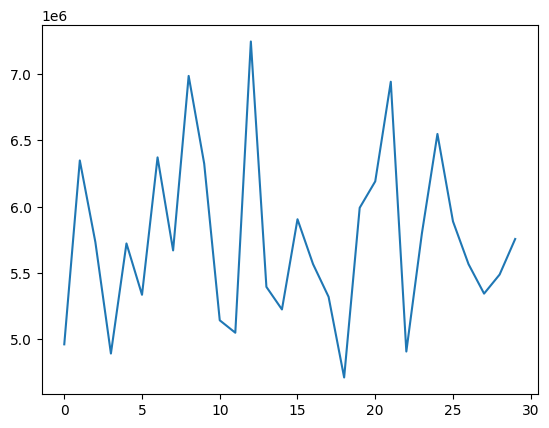

In [273]:
plt.plot(val)

In [76]:
# A2C Test Model(commission fee, rewards function: daily return)
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)


a2c_test_daily_return, a2c_test_weights = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:4313399.871994058
Sharpe:  1.2788916297700572
hit end!


In [77]:
a2c_test_weights 

,AAPL,GS,JNJ,MSFT,NKE,cash
date,,,,,,
2015-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2015-01-06,0.181692,0.162521,0.159684,0.175867,0.160968,0.159267
2015-01-07,0.171031,0.161368,0.175999,0.166138,0.166982,0.158482
2015-01-08,0.173457,0.160396,0.176105,0.162081,0.169559,0.158402
2015-01-09,0.242639,0.138040,0.138040,0.192651,0.138040,0.150590
...,...,...,...,...,...,...
2021-12-23,0.256092,0.137037,0.137037,0.183144,0.137037,0.149652
2021-12-27,0.256158,0.137006,0.137006,0.183183,0.137006,0.149640
2021-12-28,0.259867,0.134101,0.134101,0.188520,0.134101,0.149310


In [262]:
pd.options.plotting.backend = "plotly"

fig = a2c_test_weights.plot()
fig.update_layout(
    title="A2C Model(With rewards function:portfolio daily return)",
    xaxis_title="Date",
    yaxis_title="Weight",
    legend_title="Stocks",
)
fig.show()

In [164]:
a2c_test_daily_return2.to_csv('dailyreturn_rewardfunction_dailyreturn.csv')
a2c_test_weights2.to_csv('weight_rewardfunction_dailyreturn.csv')

## A2C_2

In [274]:
agent2 = DRLAgent(env = env_train2)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c_2 = agent2.get_model(model_name="a2c",model_kwargs = A2C_PARAMS,tensorboard_log="./tensorboard_log/a2c2",policy_kwargs=policy_kwargs)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device


In [275]:
for i in range (0, 30):
    trained_a2c_2 = agent2.train_model(model=model_a2c_2, 
                                tb_log_name='a2c',
                                total_timesteps=3269)

Logging to ./tensorboard_log/a2c2\a2c_1
--------------------------------------
| time/                 |            |
|    fps                | 235        |
|    iterations         | 100        |
|    time_elapsed       | 2          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -8.5       |
|    explained_variance | 0          |
|    learning_rate      | 0.0002     |
|    n_updates          | 99         |
|    policy_loss        | 2.43e+07   |
|    reward             | 1011229.75 |
|    std                | 0.997      |
|    value_loss         | 1.05e+13   |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 244       |
|    iterations         | 200       |
|    time_elapsed       | 4         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -8.5      |
|    explained_variance | 0     

In [276]:
val2 = [5335515,6169634,5794505,6130529,5328960,5205783,5790091,5987570,5613867,4947092,5551773,5813999,5810043,6062092,6084048,6061186,5776440,4647903,6097562,5523299,6514429,5273589,5351366,6168070,6756360,7035682,7534025,6356337,6051544,6603897]


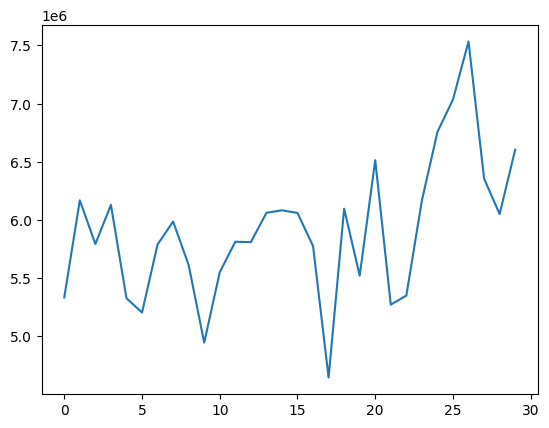

In [277]:
plt.plot(val2)

In [82]:
# A2C Test Model(commission fee, rewards function:portfolio value)
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)


a2c_test_daily_return_2, a2c_test_weights_2 = DRLAgent.DRL_prediction(model=trained_a2c_2,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:3937993.2168772835
Sharpe:  1.2387120930978246
hit end!


In [83]:
a2c_test_weights_2

,AAPL,GS,JNJ,MSFT,NKE,cash
date,,,,,,
2015-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2015-01-06,0.157368,0.157612,0.160971,0.209314,0.157368,0.157368
2015-01-07,0.158075,0.160326,0.158075,0.207373,0.158075,0.158075
2015-01-08,0.156801,0.160096,0.170732,0.198767,0.156801,0.156801
2015-01-09,0.156904,0.161962,0.171128,0.196199,0.156904,0.156904
...,...,...,...,...,...,...
2021-12-23,0.159577,0.154207,0.193069,0.184732,0.154207,0.154207
2021-12-27,0.160204,0.157368,0.190806,0.181409,0.155107,0.155107
2021-12-28,0.157838,0.159951,0.185092,0.185103,0.156008,0.156008


In [84]:
pd.options.plotting.backend = "plotly"

fig = a2c_test_weights_2.plot()
fig.update_layout(
    title="A2C Test Model(With rewards function:portfolio value)",
    xaxis_title="Date",
    yaxis_title="Weight",
    legend_title="Stocks",
)
fig.show()

In [85]:
# Class from FinRL lib that retrieving daily stock data from Yahoo Finance API
class YahooDownloader:
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API
    Attributes
    ----------
        start_date : str
            start date of the data (modified from neofinrl_config.py)
        end_date : str
            end date of the data (modified from neofinrl_config.py)
        ticker_list : list
            a list of stock tickers (modified from neofinrl_config.py)
    Methods
    -------
    fetch_data()
        Fetches data from yahoo API
    """

    def __init__(self, start_date: str, end_date: str, ticker_list: list):
        self.start_date = start_date
        self.end_date = end_date
        self.ticker_list = ticker_list

    def fetch_data(self, proxy=None) -> pd.DataFrame:
        """Fetches data from Yahoo API
        Parameters
        ----------
        Returns
        -------
        `pd.DataFrame`
            7 columns: A date, open, high, low, close, volume and tick symbol
            for the specified stock ticker
        """
        # Download and save the data in a pandas DataFrame:
       
        data_df = pd.DataFrame()
        num_failures = 0
        for tic in self.ticker_list:
            temp_df = yf.download(
                tic, start=self.start_date, end=self.end_date, proxy=proxy
            )
            temp_df["tic"] = tic
            if len(temp_df) > 0:
                data_df = pd.concat([data_df,temp_df])
            else:
                num_failures += 1
        if num_failures == len(self.ticker_list):
            raise ValueError("no data is fetched.")
        # reset the index, we want to use numbers as index instead of dates
        data_df = data_df.reset_index()
        try:
            # convert the column names to standardized names
            data_df.columns = [
                "date",
                "open",
                "high",
                "low",
                "close",
                "adjcp",
                "volume",
                "tic",
            ]
            # use adjusted close price instead of close price
            data_df["close"] = data_df["adjcp"]
            # drop the adjusted close price column
            data_df = data_df.drop(labels="adjcp", axis=1)
        except NotImplementedError:
            print("the features are not supported currently")
        # create day of the week column (monday = 0)
        data_df["day"] = data_df["date"].dt.dayofweek
        # convert date to standard string format, easy to filter
        data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
        # drop missing data
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        print("Shape of DataFrame: ", data_df.shape)
        # print("Display DataFrame: ", data_df.head())
        data_df = data_df.sort_values(by=["date", "tic"]).reset_index(drop=True)
        
        return data_df

    def select_equal_rows_stock(self, df):
        df_check = df.tic.value_counts()
        df_check = pd.DataFrame(df_check).reset_index()
        df_check.columns = ["tic", "counts"]
        mean_df = df_check.counts.mean()
        equal_list = list(df.tic.value_counts() >= mean_df)
        names = df.tic.value_counts().index
        select_stocks_list = list(names[equal_list])
        df = df[df.tic.isin(select_stocks_list)]
        return df

In [86]:
from __future__ import annotations

from copy import deepcopy

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyfolio
from pyfolio import timeseries

import config

def get_daily_return(df, value_col_name="account_value"):
    df = deepcopy(df)
    df["daily_return"] = df[value_col_name].pct_change(1)
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True, drop=True)
    df.index = df.index.tz_localize("UTC")
    return pd.Series(df["daily_return"], index=df.index)


def convert_daily_return_to_pyfolio_ts(df):
    strategy_ret = df.copy()
    strategy_ret["date"] = pd.to_datetime(strategy_ret["date"])
    strategy_ret.set_index("date", drop=False, inplace=True)
    strategy_ret.index = strategy_ret.index.tz_localize("UTC")
    del strategy_ret["date"]
    return pd.Series(strategy_ret["daily_return"].values, index=strategy_ret.index)


def backtest_stats(account_value, value_col_name="account_value"):
    dr_test = get_daily_return(account_value, value_col_name=value_col_name)
    perf_stats_all = timeseries.perf_stats(
        returns=dr_test,
        positions=None,
        transactions=None,
        turnover_denom="AGB",
    )
    print(perf_stats_all)
    return perf_stats_all


def backtest_plot(
    account_value,
    baseline_start=config.TRADE_START_DATE,
    baseline_end=config.TRADE_END_DATE,
    baseline_ticker="^DJI",
    value_col_name="account_value",
):
    df = deepcopy(account_value)
    df["date"] = pd.to_datetime(df["date"])
    test_returns = get_daily_return(df, value_col_name=value_col_name)

    baseline_df = get_baseline(
        ticker=baseline_ticker, start=baseline_start, end=baseline_end
    )

    baseline_df["date"] = pd.to_datetime(baseline_df["date"], format="%Y-%m-%d")
    baseline_df = pd.merge(df[["date"]], baseline_df, how="left", on="date")
    baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
    baseline_returns = get_daily_return(baseline_df, value_col_name="close")

    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(
            returns=test_returns, benchmark_rets=baseline_returns, set_context=False
        )


def get_baseline(ticker, start, end):
    return YahooDownloader(
        start_date=start, end_date=end, ticker_list=[ticker]
    ).fetch_data()


def trx_plot(df_trade, df_actions, ticker_list):
    df_trx = pd.DataFrame(np.array(df_actions["transactions"].to_list()))
    df_trx.columns = ticker_list
    df_trx.index = df_actions["date"]
    df_trx.index.name = ""

    for i in range(df_trx.shape[1]):
        df_trx_temp = df_trx.iloc[:, i]
        df_trx_temp_sign = np.sign(df_trx_temp)
        buying_signal = df_trx_temp_sign.apply(lambda x: x > 0)
        selling_signal = df_trx_temp_sign.apply(lambda x: x < 0)

        tic_plot = df_trade[
            (df_trade["tic"] == df_trx_temp.name)
            & (df_trade["date"].isin(df_trx.index))
        ]["close"]
        tic_plot.index = df_trx_temp.index

        plt.figure(figsize=(10, 8))
        plt.plot(tic_plot, color="g", lw=2.0)
        plt.plot(
            tic_plot,
            "^",
            markersize=10,
            color="m",
            label="buying signal",
            markevery=buying_signal,
        )
        plt.plot(
            tic_plot,
            "v",
            markersize=10,
            color="k",
            label="selling signal",
            markevery=selling_signal,
        )
        plt.title(
            f"{df_trx_temp.name} Num Transactions: {len(buying_signal[buying_signal == True]) + len(selling_signal[selling_signal == True])}"
        )
        plt.legend()
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=25))
        plt.xticks(rotation=45, ha="right")
        plt.show()

c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\pyfolio\pos.py:26: UserWarning:

Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.



In [87]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(a2c_test_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [88]:
print("==============A2C_protfolio_return Strategy Stats===========")
perf_stats_all

==============A2C_protfolio_return Strategy Stats===========


Annual return           0.232659
Cumulative returns      3.313400
Annual volatility       0.175717
Sharpe ratio            1.278892
Calmar ratio            0.809284
Stability               0.950821
Max drawdown           -0.287488
Omega ratio             1.276998
Sortino ratio           1.839115
Skew                   -0.287202
Kurtosis               12.142800
Tail ratio              0.994863
Daily value at risk    -0.021246
Alpha                   0.000000
Beta                    1.000000
dtype: float64

In [89]:
DRL_strat = convert_daily_return_to_pyfolio_ts(a2c_test_daily_return_2)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [90]:
print("==============A2C_protfolio_value Strategy Stats===========")
perf_stats_all

==============A2C_protfolio_value Strategy Stats===========


Annual return           0.216702
Cumulative returns      2.937993
Annual volatility       0.170099
Sharpe ratio            1.238712
Calmar ratio            0.777492
Stability               0.955619
Max drawdown           -0.278719
Omega ratio             1.273403
Sortino ratio           1.783188
Skew                   -0.222712
Kurtosis               14.536293
Tail ratio              0.984668
Daily value at risk    -0.020594
Alpha                   0.000000
Beta                    1.000000
dtype: float64

In [66]:
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = a2c_test_daily_return.loc[0,'date'],
        end = a2c_test_daily_return.loc[len(a2c_test_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1760, 8)
Annual return          0.110929
Cumulative returns     1.084868
Annual volatility      0.186082
Sharpe ratio           0.659348
Calmar ratio           0.299111
Stability              0.903834
Max drawdown          -0.370862
Omega ratio            1.147034
Sortino ratio          0.911857
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.912633
Daily value at risk   -0.022957
dtype: float64


c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [102]:
%matplotlib inline
baseline_df = get_baseline(
        ticker='^DJI', start=a2c_test_daily_return_2.loc[0,'date'], end='2021-12-31'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

#with pyfolio.plotting.plotting_context(font_scale=1.1):
#        pyfolio.create_full_tear_sheet(returns = DRL_strat,
 #                                      benchmark_rets=baseline_returns, set_context=False)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1761, 8)


# Mean-variance portfolio

\begin{equation*}
\begin{aligned}
& \underset{\mathbf{w}}{\text{minimize}}
& & \frac{1}{2} \mathbf{w}^T \Sigma \mathbf{w} \
& \text{subject to}
& & \mathbf{w}^T \mathbf{r} - r_f \geq \mu \
& & & \mathbf{1}^T \mathbf{w} = 1 \
& & & w_i \geq 0, \quad i=1,\ldots,n,
\end{aligned}
\end{equation*}

where $\mathbf{w}$ is the vector of portfolio weights, $\Sigma$ is the covariance matrix of asset returns, $\mathbf{r}$ is the vector of expected returns, $r_f$ is the risk-free rate, $\mu$ is the minimum required return, and $\mathbf{1}$ is a vector of ones. The first constraint ensures that the portfolio return is at least $\mu$, while the second constraint enforces the requirement that the weights add up to 1. The last constraint requires non-negative weights.

In [133]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.2))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()
    
    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value 
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)
    
portfolio=portfolio.T
portfolio.columns = ['account_value']

portfolio.head()

,account_value
2015-01-05,1000000
2015-01-06,992329.467216
2015-01-07,1005727.056062
2015-01-08,1023535.152336
2015-01-09,1015462.060985


In [ ]:
returns = portfolio['account_value'].pct_change()

In [163]:
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=returns, 
                              factor_returns=returns, 
                                positions=None, transactions=None, turnover_denom="AGB")

c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [164]:
perf_stats_all

Annual return           0.179923
Cumulative returns      2.175670
Annual volatility       0.157629
Sharpe ratio            1.128866
Calmar ratio            0.657486
Stability               0.947121
Max drawdown           -0.273653
Omega ratio             1.243973
Sortino ratio           1.618136
Skew                   -0.260181
Kurtosis               13.687694
Tail ratio              0.959133
Daily value at risk    -0.019153
Alpha                   0.000000
Beta                    1.000000
dtype: float64

## uniform portfolio

In [99]:
from collections import OrderedDict
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

portfolio2 = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio2.loc[0,unique_trade_date[0]] = initial_capital
weights = OrderedDict()
weights['AAPL'] = 1/6
weights['GS'] = 1/6
weights['JNJ'] = 1/6
weights['MSFT'] = 1/6
weights['NKE'] = 1/6
weights['cash'] = 1/6

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    #current capital
    cap = portfolio2.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(weights.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value 
    portfolio2.iloc[0, i+1] = np.dot(current_shares, next_price)
    
portfolio2=portfolio2.T
portfolio2.columns = ['account_value']

portfolio2.head()

,account_value
2015-01-05,1000000
2015-01-06,992442.74957
2015-01-07,1006440.679099
2015-01-08,1025733.735543
2015-01-09,1017687.085558


In [166]:
retunrs_2 = portfolio2['account_value'].pct_change()

In [148]:
(retunrs_2.mean()-0.005921*0.01) / returns.std() * 252 ** 0.5

1.2239454924561397

In [168]:
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=retunrs_2, 
                              factor_returns=retunrs_2, 
                                positions=None, transactions=None, turnover_denom="AGB")

c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [169]:
perf_stats_all

Annual return          0.213435
Cumulative returns     2.864706
Annual volatility      0.168484
Sharpe ratio           1.233656
Calmar ratio           0.762696
Stability              0.951558
Max drawdown          -0.279843
Omega ratio            1.271071
Sortino ratio          1.774049
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.993938
Daily value at risk   -0.020402
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [103]:
a2c_2_cumpod =(a2c_test_daily_return_2.daily_return+1).cumprod()-1
a2c_cumpod =(a2c_test_daily_return.daily_return+1).cumprod()-1
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1
dji_cumpod =(baseline_returns+1).cumprod()-1
uniform_cumpod =(portfolio2.account_value.pct_change()+1).cumprod()-1

In [104]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [239]:
time_ind = pd.Series(a2c_test_daily_return_2.date)
trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C (Portfolio Return)')
trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')
trace3_portfolio = go.Scatter(x = time_ind, y = a2c_2_cumpod, mode = 'lines', name = 'A2C (Portfolio Value)')
trace4_portfolio = go.Scatter(x = time_ind, y = uniform_cumpod, mode = 'lines', name = 'Uniform')

In [240]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)

fig.add_trace(trace1_portfolio)

fig.add_trace(trace2_portfolio)

fig.add_trace(trace3_portfolio)

fig.add_trace(trace4_portfolio)


fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={ 'type': 'date',
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80*3}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()

In [260]:
time_ind = pd.Series(a2c_test_daily_return_2.date)
stock1 = go.Scatter(y = adj_close_y['AAPL'].pct_change(1).cumsum(), x =time_ind, mode = 'lines', name = 'AAPL')
stock2 = go.Scatter(y = adj_close_y['GS'].pct_change(1).cumsum(), x =time_ind, mode = 'lines', name = 'GS')
stock3 = go.Scatter(y = adj_close_y['JNJ'].pct_change(1).cumsum(), x =time_ind, mode = 'lines', name = 'JNJ')
stock4 = go.Scatter(y = adj_close_y['MSFT'].pct_change(1).cumsum(), x =time_ind, mode = 'lines', name = 'MSFT')
stock5 = go.Scatter(y = adj_close_y['NKE'].pct_change(1).cumsum(), x =time_ind, mode = 'lines', name = 'NKE')
stock6 = go.Scatter(y = ts, x =time_ind, mode = 'lines', name = 'cash')



In [261]:
fig = go.Figure()
fig.add_trace(stock1)

fig.add_trace(stock2)

fig.add_trace(stock3)

fig.add_trace(stock4)

fig.add_trace(stock5)

fig.add_trace(stock6)

fig.add_trace(trace0_portfolio)

fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={ 'type': 'date',
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80*3}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()

In [249]:
df = (eff_rate[3522:] * 0.01).cumsum()

In [251]:
df

,Rate (%)
Date,
2015-01-06,0.000005
2015-01-07,0.000010
2015-01-08,0.000014
2015-01-09,0.000019
2015-01-12,0.000024
...,...
2021-12-27,0.059460
2021-12-28,0.059463
2021-12-29,0.059467


In [255]:
ts = pd.Series(df['Rate (%)'].values, index=df.index)

In [256]:
ts

Date
2015-01-06    0.000005
2015-01-07    0.000010
2015-01-08    0.000014
2015-01-09    0.000019
2015-01-12    0.000024
                ...   
2021-12-27    0.059460
2021-12-28    0.059463
2021-12-29    0.059467
2021-12-30    0.059470
2021-12-31    0.059473
Length: 1759, dtype: float64

In [257]:
fig = go.Figure()
fig.add_trace(go.Scatter(y = ts, x =time_ind, mode = 'lines', name = 'cash'))

In [207]:
eff_rate

,Rate (%)
Date,
2001-01-02,0.026468
2001-01-03,0.025198
2001-01-04,0.023492
2001-01-05,0.023135
2001-01-08,0.023730
...,...
2020-12-24,0.000357
2020-12-28,0.000357
2020-12-29,0.000357


In [278]:
result = pd.read_csv('a2c_3.csv')

In [279]:
result

,Wall time,Step,Value
0,1.680370e+09,500,0.166518
1,1.680370e+09,1000,0.034463
2,1.680370e+09,1500,0.012987
3,1.680370e+09,2000,0.008168
4,1.680370e+09,2500,0.021968
...,...,...,...
195,1.680370e+09,98000,0.000025
196,1.680370e+09,98500,0.000147
197,1.680370e+09,99000,0.000738
198,1.680370e+09,99500,0.000075


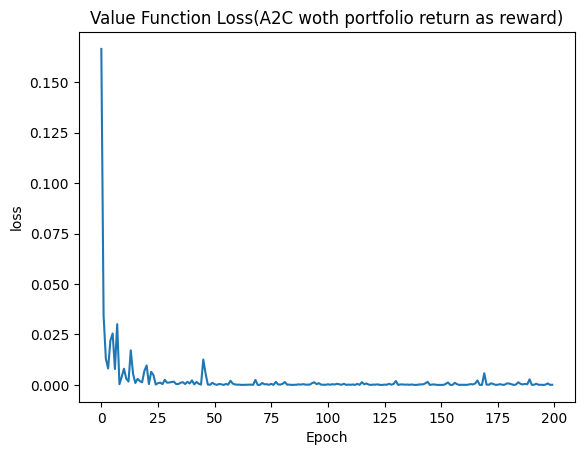

In [290]:
plt.plot(result['Value'])
plt.title('Value Function Loss(A2C woth portfolio return as reward)')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.savefig('a2c_111.png')
plt.show()

In [280]:
result2 = pd.read_csv('a2c_2_2.csv')

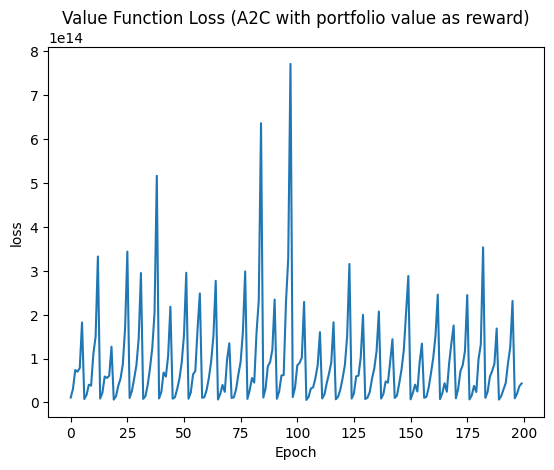

In [291]:
plt.plot(result2['Value'])
plt.title('Value Function Loss (A2C with portfolio value as reward)')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.savefig('a2c_222.png')
plt.show()